# Config

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scipy.spatial
import matplotlib.patches as mpatches
import string

from omegaconf import OmegaConf
import pytorch_lightning as pl

In [4]:
DATA_PATH = '/braid/havivd/scgen/kang_scimilarity.h5ad'
MODEL_PATH = '/braid/havivd/scgen/kang_model_params.pth'
USE_SAVED_MODEL = False
OVERWRITE_SAVED_MODEL = False
OBSM_KEY = 'X_pca'
Z_SCORE = False
CONCEPT_KEY = 'concepts'
RANDOM_SEED = 2

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
# --- Plotting Configuration ---
CT_CMAP = {
    'B cells': "#e91111", 'CD4 T cells': '#048757', 'CD8 T cells': '#9cdb97',
    'CD14+ Monocytes': '#90e0ef', 'Dendritic cells': '#ffb72a',
    'FCGR3A+ Monocytes': '#b18bda', 'Megakaryocytes': '#c5c5b6', 'NK cells': '#51696c'
}
STIM_CMAP = {'ctrl': '#fcb6b1', 'stim': '#c44536'}
# IDENT_CMAP = {
#     'train': '#676765', 'held out for intervention': '#c84639',
#     'held out as GT': '#048757', 'intervened on': '#06d400'
# }

IDENT_CMAP = {
    'train': '#676765', 'intervention': '#c84639','held out for intervention': '#c84639',
    'held out as GT': '#048757', 'intervened on': '#06d400'
}

TITLE_MAP = {'cell': 'Cell Type', 'stim': 'State', 'ident': 'Split'}

# DATA LOADING AND PREPARATION

In [6]:
# def split_data_for_counterfactuals(adata, hold_out_label, mod_label, p_intervention=0.2):
#     """Splits data into train, intervention, and ground truth sets."""
#     print("Splitting data for counterfactual experiment...")
#     labels = adata.obs['cell_stim']
#     is_test = (labels == hold_out_label)
#     is_inter_pool = (labels == mod_label)

#     # Create a random mask to select a subset for intervention
#     inter_mask = np.random.binomial(1, p=p_intervention, size=is_inter_pool.sum()).astype(bool)
#     is_inter = np.zeros_like(labels, dtype=bool)
#     is_inter[is_inter_pool] = inter_mask
    
#     is_train = ~is_test & ~is_inter

#     # Create AnnData objects for each split
#     adata_train = adata[is_train].copy()
#     adata_test = adata[is_test].copy()
#     adata_inter = adata[is_inter].copy()

#     # Store split identifiers in the original object for later merging
#     ident_vec = np.array(['train'] * len(adata)).astype('<U32')
#     ident_vec[is_test] = 'held out as GT'
#     ident_vec[is_inter] = 'held out for intervention'
#     adata.obs['ident'] = ident_vec
    
#     print(f"Train set: {len(adata_train)} cells")
#     print(f"Intervention set: {len(adata_inter)} cells")
#     print(f"Ground Truth set: {len(adata_test)} cells")

#     return adata, adata_train, adata_test, adata_inter


def split_data(adata, hold_out_label, mod_label):
    """
    Splits data into train, intervention, and ground truth sets.

    - Ground Truth: All cells with the `hold_out_label`.
    - Intervention: All cells with the `mod_label`.
    - Train: All remaining cells.
    """
    print("Splitting data with simplified logic...")
    labels = adata.obs['cell_stim']

    # Define the three disjoint sets based on their labels
    is_test = (labels == hold_out_label)
    is_inter = (labels == mod_label)
    is_train = ~is_test

    # Create AnnData objects for each split
    adata_train = adata[is_train].copy()
    adata_test = adata[is_test].copy()
    adata_inter = adata[is_inter].copy()

    # Store split identifiers in the original object
    ident_vec = np.array(['train'] * len(adata)).astype('<U32')
    ident_vec[is_test] = 'held out as GT'
    ident_vec[is_inter] = 'intervention'
    adata.obs['ident'] = ident_vec
    

    return adata, adata_train, adata_test, adata_inter



# MODELING & PREDICTION METHODS

## Method 1: scCBGM

In [7]:


def train_method_1_cbgm(adata_train, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Trains and returns the scCBGM model."""
    print("Training scCBGM model...")

    # --- MODIFICATION START ---
    # Conditionally set the data source and input dimension based on the 'pca' flag
    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization

    # --- MODIFICATION END ---

    torch.set_flush_denormal(True)

    config = OmegaConf.create(dict(
        has_cbm=True, 
        lr=5e-4, 
        hidden_dim=1024, 
        n_layers = 4,
        beta=1e-5,
        input_dim=data_matrix.shape[-1],  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].shape[1],
        min_bottleneck_size=128, independent_training=True,
        concepts_hp=0.1, orthogonality_hp=0.5, use_soft_concepts=False
    ))
    model = clab.models.scCBGM(config)

    model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return model

def predict_with_method_1_cbgm(model, adata_inter, hold_out_label, obsm_key = OBSM_KEY):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with scCBGM...")
    if(obsm_key != 'X'):
        x_intervene_on =  torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds['x_pred'].cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


##  Method 2: Flow Matching with Learned Concepts

In [8]:
def get_learned_concepts(scCBGM_model, adata_full, obsm_key = OBSM_KEY):
    """Uses a trained scCBGM to generate learned concepts for all data."""
    print("Generating learned concepts from scCBGM...")

    if(obsm_key != 'X'):
        all_x = torch.tensor(adata_full.obsm[obsm_key], dtype=torch.float32).to('cuda')
    else:
        all_x = torch.tensor(adata_full.X, dtype=torch.float32).to('cuda')

    with torch.no_grad():
        enc = scCBGM_model.encode(all_x)
        adata_full.obsm['scCBGM_concepts_known'] = scCBGM_model.cb_concepts_layers(enc['mu']).cpu().numpy()
        adata_full.obsm['scCBGM_concepts_unknown'] = scCBGM_model.cb_unk_layers(enc['mu']).cpu().numpy()

    adata_full.obsm['scCBGM_concepts'] = np.concatenate([adata_full.obsm['scCBGM_concepts_known'], adata_full.obsm['scCBGM_concepts_unknown']], axis=1)
    return adata_full

def train_method_2_fm_learned(adata_train, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Conditonal Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization

    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm['scCBGM_concepts'].shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm['scCBGM_concepts'].astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def predict_with_method_2_fm_learned(model, adata_inter, hold_out_label, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")
    c_known_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_known'].astype(np.float32))
    c_unknown_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_unknown'].astype(np.float32))
    
    inter_concepts_known = c_known_inter.clone()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    
    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X
        if(z_score):
            x_inter = (x_inter - adata_inter.var['mean'].to_numpy()[None, :]) / adata_inter.var['std'].to_numpy()[None, :]

    init_concepts = np.concatenate([c_known_inter, c_unknown_inter], axis=1)
    edit_concepts = np.concatenate([inter_concepts_known, c_unknown_inter], axis=1)

    inter_preds = model.edit(
             x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
             c = torch.from_numpy(init_concepts.astype(np.float32)).to('cuda'),
             c_prime = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
             t_edit = 0.1,
             n_steps = 1000,
             w_cfg_forward = 1.0,
             w_cfg_backward = 1.0,
             noise_add = 0.0)
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds

    return pred_adata




## Method 3: Concept Flows



In [9]:
def train_method_3_concept_flows(adata_train, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Concept Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization
            
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].to_numpy().shape[1],
        n_unknown=128,
        n_layers=4,
        dropout=0.1,
        p_uncond=0.0,
        kl_hp=0.2,
        flow_hp=1.0,
        concepts_hp=0.2,
        orthogonality_hp=0.5)

    fm_model = clab.models.concept_fm.Concept_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model

def predict_with_method_3_concept_flows(model, adata_inter, hold_out_label, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with concept flow...")


    if(obsm_key != 'X'):
        data_matrix = adata_inter.obsm[obsm_key]
    else:
        data_matrix = adata_inter.X
        if(z_score):
            data_matrix = (data_matrix - adata_inter.var['mean'].to_numpy()[None, :]) / adata_inter.var['std'].to_numpy()[None, :]  # Z-score normalization

    x_intervene_on = torch.from_numpy(data_matrix.astype(np.float32))
    c_intervene_on = torch.from_numpy(adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32))

    inter_concepts_known = c_intervene_on.clone()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    
    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))

    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds

    return pred_adata


## Method 4: Flow Matching with Raw Concepts 

In [10]:

def train_method_4_fm_raw(adata_train, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Trains and returns the CB-FM model using learned concepts."""

    print("Training Conditonal Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization

    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].to_numpy().shape[1],
        n_layers=4,
        dropout=0.1)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model

def predict_with_method_4_fm_raw(model, adata_inter, hold_out_label, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Performs intervention using a trained raw-concept CB-FM model."""
    print("Performing intervention with CB-FM (raw)...")
    c_intervene_on = torch.from_numpy(adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32))
    inter_concepts = c_intervene_on.clone()
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.decode(
            h=inter_concepts.to('cuda'),
            n_steps=1000,
        )
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds

    return pred_adata



def predict_with_method_4_fm_raw_edit(model, adata_inter, hold_out_label, obsm_key = OBSM_KEY, z_score = Z_SCORE):
    """Performs intervention using a trained raw-concept CB-FM model."""
    print("Performing intervention with CB-FM (raw)...")
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")
    init_concepts = torch.from_numpy(adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32))

    edit_concepts = init_concepts.clone()
    edit_concepts[:, -1] = 1 # Set stim concept to 1

    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X
        if(z_score):
            x_inter = (x_inter - adata_inter.var['mean'].to_numpy()[None, :]) / adata_inter.var['std'].to_numpy()[None, :]


    inter_preds = model.edit(
             x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
             c = init_concepts.to('cuda'),
             c_prime = edit_concepts.to('cuda'),
             t_edit = 0.2,
             n_steps = 1000,
             w_cfg_forward = 1.0,
             w_cfg_backward = 1.0,
             noise_add = 0.0)
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds

    return pred_adata


# Plotting

In [11]:
def analyze_and_plot_results(adata_original, pred_adata, method_name, score, obsm_key = OBSM_KEY):
    """Merges data, runs UMAP, calculates error, and plots the results."""
    print(f"Analyzing and plotting results for {method_name}...")
    
    # Keep only the original data splits, not the predicted one
    adata_to_merge = adata_original[adata_original.obs['ident'] != 'intervened on'].copy()

    # Merge original data with the new prediction
    adata_merged = ad.concat([adata_to_merge, pred_adata], join='inner', merge='unique')
    
    # Add other metadata for coloring
    adata_merged.obs['cell'] = [label.split('_')[0] for label in adata_merged.obs['cell_stim']]
    adata_merged.obs['stim'] = ['stim' if 'stim' in label else 'ctrl' for label in adata_merged.obs['cell_stim']]

    # Dimensionality Reduction for visualization
    #sc.pp.pca(adata_merged)
    
    #adata_merged.obsm['X_pca'] = adata_merged.X
    # check if obsm has X_pca:

    if obsm_key == 'X':
        sc.pp.pca(adata_merged)
    else:
        print(f"using pre computed {obsm_key}")
        
    

    sc.pp.neighbors(adata_merged, use_rep='X_pca' if obsm_key=='X' else obsm_key)
    sc.tl.umap(adata_merged, random_state=RANDOM_SEED)

    # # Set plotting order
    # adata_merged.obs['ident'] = pd.Categorical(adata_merged.obs['ident'],
    #     categories=['train', 'intervention', 'held out as GT', 'intervened on'])

    adata_merged.obs['ident'] = pd.Categorical(adata_merged.obs['ident'])
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 5), constrained_layout=True)
    fig.suptitle(f"Counterfactual Prediction Results: {method_name}", fontsize=20)
    
    cmaps = [CT_CMAP, STIM_CMAP, IDENT_CMAP]
    color_keys = ['cell', 'stim', 'ident']

    for i, (ax, cmap, key) in enumerate(zip(axes, cmaps, color_keys)):
        sc.pl.umap(adata_merged, color=key, ax=ax, show=False, palette=cmap, s=10,
                   title=f"{string.ascii_uppercase[i]}) {TITLE_MAP[key]}")
        
        # Add error to the title of the last plot
        if key == 'ident':
            ax.set_title(f"{ax.get_title()}, rMMD score {score:.2f}")

            # Add intervention arrow
            source_coords = adata_merged[adata_merged.obs['ident'] == 'intervention'].obsm['X_umap'].mean(0)
            #source_coords = adata_merged[adata_merged.obs['ident'] == 'held out for intervention'].obsm['X_umap'].mean(0)
            target_coords = adata_merged[adata_merged.obs['ident'] == 'intervened on'].obsm['X_umap'].mean(0)
            arrow = mpatches.FancyArrowPatch(
                source_coords, target_coords,
                connectionstyle="arc3,rad=0.3", arrowstyle="-|>",
                linewidth=2, linestyle='dashed', color="black", mutation_scale=20
            )
            ax.add_patch(arrow)
            
    plt.show()


# Main

## Proccesing

In [12]:
import sklearn.decomposition

In [13]:
print("Loading and preprocessing data...")
adata = ad.read_h5ad(DATA_PATH)
sc.pp.normalize_total(adata, target_sum=np.median(adata.X.toarray().sum(axis=1)))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset=True)

adata.X = adata.X.toarray()

Loading and preprocessing data...


### Check L1 and L2 cell types

In [14]:
adata.obs['cell_types_L1'] = adata.obs['cell']
adata.obs['cell_types_L2'] = adata.obs['celltype_hint']

In [15]:
obs_df = adata.obs.copy()

In [16]:

proportion_crosstab = pd.crosstab(obs_df['cell_types_L2'], obs_df['cell_types_L1'], normalize='index')
proportion_crosstab

cell_types_L1,B cells,CD4 T cells,CD8 T cells,CD14+ Monocytes,Dendritic cells,FCGR3A+ Monocytes,Megakaryocytes,NK cells
cell_types_L2,,,,,,,,
CD1c-positive myeloid dendritic cell,0.000000,0.000000,0.000000,0.008850,0.938053,0.053097,0.000000,0.000000
"CD4-positive, CD25-positive, alpha-beta regulatory T cell",0.002873,0.975400,0.017059,0.000180,0.000359,0.000539,0.001257,0.002334
"CD16-negative, CD56-bright natural killer cell, human",0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.950000
"CD16-positive, CD56-dim natural killer cell, human",0.000000,0.001779,0.017794,0.000000,0.000000,0.000000,0.007117,0.973310
CD141-positive myeloid dendritic cell,0.000000,0.000000,0.000000,0.000000,0.964286,0.000000,0.035714,0.000000
T follicular helper cell,0.057971,0.920290,0.007246,0.000000,0.007246,0.007246,0.000000,0.000000
"central memory CD4-positive, alpha-beta T cell",0.000000,0.829268,0.000000,0.000000,0.024390,0.000000,0.146341,0.000000
"central memory CD8-positive, alpha-beta T cell",0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.200000
classical monocyte,0.000314,0.000471,0.000000,0.828307,0.023406,0.142004,0.004713,0.000785


In [17]:
row_normalized_crosstab = pd.crosstab(
    obs_df['cell_types_L2'], 
    obs_df['stim'], 
    normalize='index'
)

print("Proportion of each subtype found in 'ctrl' vs. 'stim':")
print((row_normalized_crosstab * 100).round(2))

Proportion of each subtype found in 'ctrl' vs. 'stim':
stim                                                 stim   ctrl
cell_types_L2                                                   
CD1c-positive myeloid dendritic cell                13.27  86.73
CD4-positive, CD25-positive, alpha-beta regulat...  43.33  56.67
CD16-negative, CD56-bright natural killer cell,...  97.50   2.50
CD16-positive, CD56-dim natural killer cell, human  97.69   2.31
CD141-positive myeloid dendritic cell               10.71  89.29
T follicular helper cell                            89.86  10.14
central memory CD4-positive, alpha-beta T cell      97.56   2.44
central memory CD8-positive, alpha-beta T cell      40.00  60.00
classical monocyte                                  50.02  49.98
effector memory CD4-positive, alpha-beta T cell     58.16  41.84
effector memory CD8-positive, alpha-beta T cell     69.79  30.21
germinal center B cell                              76.11  23.89
mature NK T cell                   

In [18]:
thresh_unique = 0.85
thresh_balance = 0.75

max_l1_proportion = proportion_crosstab.max(axis=1)

# Get the names of subtypes that meet the uniqueness threshold.
pure_subtypes = max_l1_proportion[max_l1_proportion > thresh_unique].index


# --- 3. Apply the Balance Filter ---
# Find the max proportion for each L2 subtype across 'ctrl' and 'stim'.
max_condition_proportion = row_normalized_crosstab.max(axis=1)

# Get the names of subtypes that meet the balance threshold.
balanced_subtypes = max_condition_proportion[max_condition_proportion < thresh_balance].index


# --- 4. Find the Intersection ---
# Find the subtypes that are in BOTH lists.
candidate_subtypes = pure_subtypes.intersection(balanced_subtypes)


# --- 5. Display the Results ---
print(f"--- Found {len(candidate_subtypes)} Candidate Subtypes ---")
print(list(candidate_subtypes))

--- Found 6 Candidate Subtypes ---
['CD4-positive, CD25-positive, alpha-beta regulatory T cell', 'effector memory CD8-positive, alpha-beta T cell', 'memory B cell', 'naive thymus-derived CD4-positive, alpha-beta T cell', 'non-classical monocyte', 'plasmacytoid dendritic cell']


### Test Train Split

In [19]:
L2_inter = 'effector memory CD8-positive, alpha-beta T cell'

In [20]:
hold_out_label = 'CD8 T cells_stim'
mod_label = 'CD8 T cells_ctrl'


adata, adata_train, adata_test, adata_inter = split_data(
    adata, hold_out_label, mod_label
)

adata_test = adata_test[adata_test.obs['cell_types_L2'] == L2_inter]
adata_inter = adata_inter[adata_inter.obs['cell_types_L2'] == L2_inter]



Splitting data with simplified logic...


In [21]:

adata_test = adata_test[adata_test.obs['cell_types_L2'] == L2_inter]
adata_inter = adata_inter[adata_inter.obs['cell_types_L2'] == L2_inter]


In [22]:
print(f"Train set: {len(adata_train)} cells")
print(f"Intervention set: {len(adata_inter)} cells")
print(f"Ground Truth set: {len(adata_test)} cells")

Train set: 23324 cells
Intervention set: 110 cells
Ground Truth set: 220 cells


In [23]:
adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X)

for x_data in [adata, adata_train, adata_test, adata_inter]:
    x_data.uns['pc_transform'] = adata.uns['pc_transform']
    x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X)



/tmp/ipykernel_1535803/2738433446.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  x_data.uns['pc_transform'] = adata.uns['pc_transform']
/tmp/ipykernel_1535803/2738433446.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  x_data.uns['pc_transform'] = adata.uns['pc_transform']


## --- Method 1: scCBGM ---


In [24]:
cbgm_model = train_method_1_cbgm(adata_train.copy())


Training scCBGM model...
Starting training on cuda for 200 epochs...


Training Progress: 100%|█████████████████████████████████████| 200/200 [02:45<00:00,  1.21it/s, avg_loss=6.885e-03, concept_f1=1.0000, lr=1.64990e-04]

Training finished.


In [25]:
pred_adata_cbgm = predict_with_method_1_cbgm(cbgm_model, adata_inter.copy(), hold_out_label)

Performing intervention with scCBGM...


In [26]:
score_cbfm_learned_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_train.X,
    x_ivn=pred_adata_cbgm.obsm[OBSM_KEY] if OBSM_KEY!='X' else pred_adata_cbgm.X,
    x_target=adata_test.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values)



In [27]:
score_cbfm_learned_mmd

{'mmd_ratio': np.float64(0.16111657738542473),
 'pre_computed_mmd_train': np.float64(0.3698524946360453)}

Analyzing and plotting results for Method 1: scCBGM...
using pre computed X_pca


/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


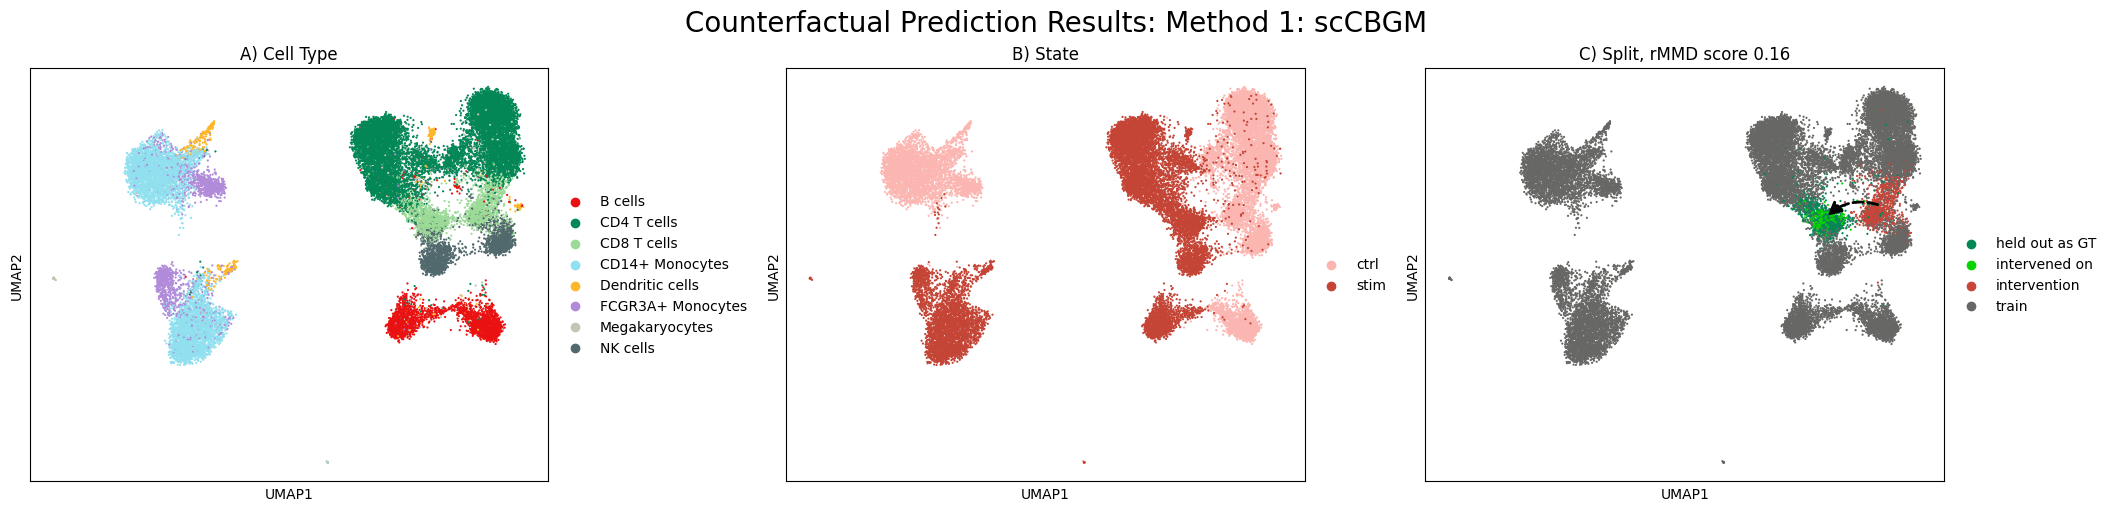

In [28]:
analyze_and_plot_results(adata, pred_adata_cbgm, "Method 1: scCBGM", score_cbfm_learned_mmd['mmd_ratio'])

## --- Method 2: CB-FM with Learned Concepts ---


In [29]:
adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
# Distribute the newly generated concepts to the training set
adata_train.obsm['scCBGM_concepts'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts']
adata_inter.obsm['scCBGM_concepts'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts']

adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

Generating learned concepts from scCBGM...


In [30]:
fm_learned_model = train_method_2_fm_learned(adata_train.copy())

Training Conditonal Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|██████| 200/200 [01:41<00:00,  1.96it/s, avg_loss=3.253e-01, lr=1.64990e-04]


In [31]:
pred_adata_fm_learned = predict_with_method_2_fm_learned(fm_learned_model, adata_inter.copy(), hold_out_label)

Performing intervention with CB-FM (learned)...
Editing from t=1.0 back to t=0.10, then forward with new condition.


In [32]:


score_fm_learned_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_train.X,
    x_ivn=pred_adata_fm_learned.obsm[OBSM_KEY] if OBSM_KEY!='X' else pred_adata_fm_learned.X,
    x_target=adata_test.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values,
    pre_computed_mmd_train=score_cbfm_learned_mmd['pre_computed_mmd_train']
)


In [33]:
score_fm_learned_mmd

{'mmd_ratio': np.float64(0.10565774670138503),
 'pre_computed_mmd_train': np.float64(0.3698524946360453)}

Analyzing and plotting results for Method 2: CB-FM (Learned Concepts)...
using pre computed X_pca


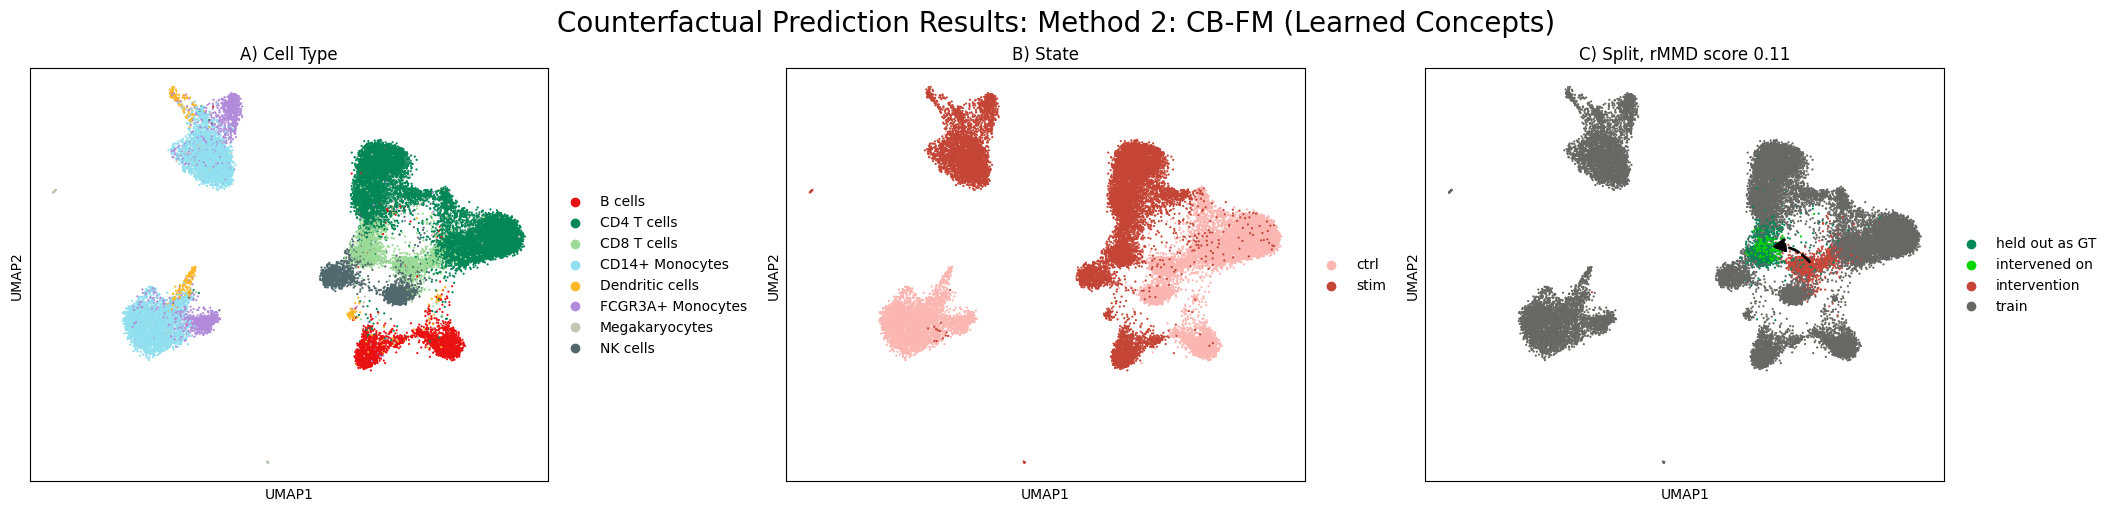

In [34]:
analyze_and_plot_results(adata, pred_adata_fm_learned, "Method 2: CB-FM (Learned Concepts)", score_fm_learned_mmd['mmd_ratio'])

## --- Method #3: Concept Flows ---


In [35]:
concept_flow_model = train_method_3_concept_flows(adata_train.copy())

Training Concept Flow Model
Concept_FM(
  (condition_embedder): ConditionEmbedding(
    (linear): Linear(in_features=137, out_features=1024, bias=True)
  )
  (_encoder): DenseEncoder(
    (x_embedder): Linear(in_features=128, out_features=1024, bias=True)
    (layers): ModuleList(
      (0-3): 4 x FeedForwardBlock(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (output_layer): Linear(in_features=1024, out_features=128, bias=True)
    (output_layer_activation): Identity()
  )
  (cb_concepts_layers): DenseEncoder(
    (x_embedder): Linear(in_features=128, out_features=1024, bias=True)
    (layers): ModuleList(
      (0-1): 2 x FeedForwardBlock(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (act

Training Progress: 100%|███████████████████████████████| 200/200 [04:32<00:00,  1.36s/it, avg_loss=2.648e-01, fm_loss=1.553e-01, concept_f1=1.000e+00]


In [36]:
pred_adata_concept_flow = predict_with_method_3_concept_flows(concept_flow_model, adata_inter.copy(), hold_out_label)

/tmp/ipykernel_1535803/1768501234.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)


Performing intervention with concept flow...
Decoding with 1000 steps and cfg_strength 1.0


In [37]:


score_fm_cf_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_train.X,
    x_ivn=pred_adata_concept_flow.obsm[OBSM_KEY] if OBSM_KEY!='X' else pred_adata_concept_flow.X,
    x_target=adata_test.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values,
    pre_computed_mmd_train=score_cbfm_learned_mmd['pre_computed_mmd_train']
)


In [38]:
score_fm_cf_mmd

{'mmd_ratio': np.float64(0.11543128062675485),
 'pre_computed_mmd_train': np.float64(0.3698524946360453)}

Analyzing and plotting results for Method 3: Concept Flow...
using pre computed X_pca


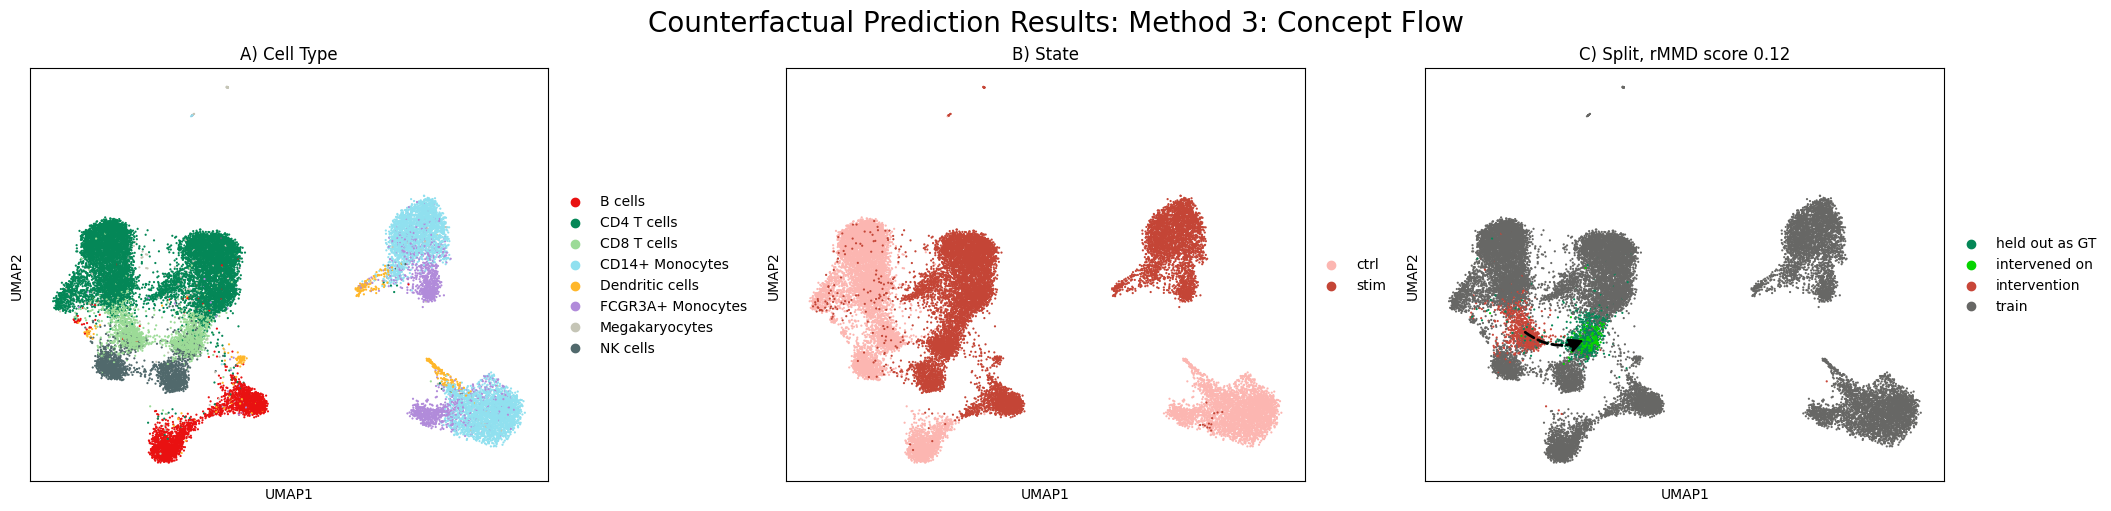

In [39]:
analyze_and_plot_results(adata, pred_adata_concept_flow, "Method 3: Concept Flow", score_fm_cf_mmd['mmd_ratio'])

## --- Method 4: CB-FM with Raw Concepts ---


In [40]:
fm_raw_model = train_method_4_fm_raw(adata_train.copy())

Training Conditonal Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|██████| 200/200 [01:45<00:00,  1.90it/s, avg_loss=6.645e-01, lr=1.64990e-04]


In [41]:
pred_adata_fm_raw = predict_with_method_4_fm_raw(fm_raw_model, adata_inter.copy(), hold_out_label)

Performing intervention with CB-FM (raw)...
Decoding with 1000 steps and CFG scale w=1.0


In [42]:
score_fm_raw_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_train.X,
    x_ivn=pred_adata_fm_raw.obsm[OBSM_KEY] if OBSM_KEY!='X' else pred_adata_concept_flow.X,
    x_target=adata_test.obsm[OBSM_KEY] if OBSM_KEY!='X' else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values,
    pre_computed_mmd_train=score_cbfm_learned_mmd['pre_computed_mmd_train']
)



In [43]:
score_fm_raw_mmd

{'mmd_ratio': np.float64(0.135058785634416),
 'pre_computed_mmd_train': np.float64(0.3698524946360453)}

Analyzing and plotting results for Method 4: Raw Flow...
using pre computed X_pca


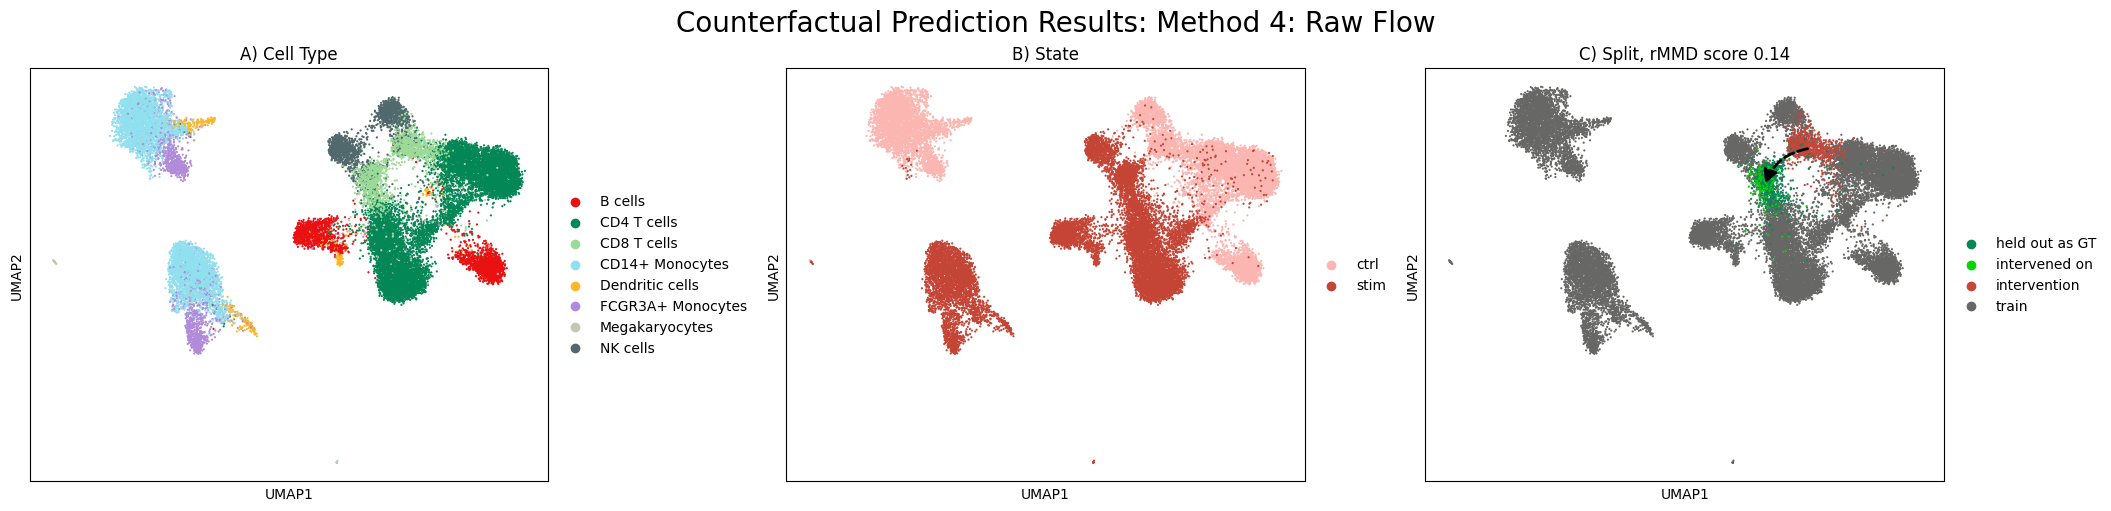

In [44]:
analyze_and_plot_results(adata, pred_adata_fm_raw, "Method 4: Raw Flow", score_fm_raw_mmd['mmd_ratio'])

In [47]:
np.mean(adata.obs['cell'] == 'Megakaryocytes')

np.float64(0.008654797230464886)